### Plotting of Immune biomarkers Figure 2
update of the script, adding in figure reordering 

In [1]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 100)

wd = "/workspace/projects//immune_biomarkers/repo/immune_biomarkers/"
setwd(wd)

source(paste0(wd,"/mission_control/treasure_map.R"))
source(paste0(wd,"/mission_control/helpers/figures/exhaustive_plots.R"))
source(paste0(wd,"/mission_control/helpers/figures/exhaustive_settings.R"))
source(paste0(wd,"/mission_control/helpers/figures/themes.R"))

library(tidyverse)
library(ggrepel)
library(data.table)
library(gridExtra)
library(ggpubr)
library(Hmisc)
library(ggh4x)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The foll

### Figure 2A

In [2]:
# UPDATE: with the new OS non-residual scores, we will lose another 4 genes. these are removed in the file below:
geneset_filtered_filtered = data.table::fread("ref/Table_S2_255_genesets.csv")

In [3]:
ingredients <- readRDS(paste0(TMP_DIR,"exhaustive-plots-base.Rds"))

In [4]:
# save table S3 
ingredients_select  = ingredients  %>% 
    dplyr::select(dataset, model, model_type, Type, feature_group, feature, est,log10_p)  %>% 
    mutate(simplename = gsub("gene_set_|isofox_", "", feature))  %>%  
    mutate(simplename = gsub("mariathan_", "m_", tolower(simplename)))

In [5]:
ingredients_other = ingredients_select   %>% filter(!grepl(pattern = "gene_set_", x = feature)) 
ingredients_gene_set = ingredients_select  %>% 
    filter(grepl("gene_set", feature))  %>% 
    filter(simplename %in% geneset_filtered_filtered$simplename)

In [6]:
table_S3 = rbind(ingredients_other, ingredients_gene_set)  %>% 
    arrange(dataset, model, model_type, Type, feature_group, feature)  %>% 
    select(-simplename)

In [7]:
#readr::write_excel_csv(table_S3, "1_figures/figure2/Table_S3.csv")

In [8]:
ingredients <- readRDS(paste0(TMP_DIR,"exhaustive-plots-base.Rds"))
threshold <- -log10(ingredients$by_05_fdr[1])

In [9]:
labels <- readRDS(paste0(TMP_DIR,"exhaustive-plots-labels.Rds"))

In [10]:
drop_features <- c("tcell", "tmb", "prolif","tgfb","pretreat","pretreat_comp","tissue",
                   "tissue_full","age","biopsy","purity","pdl1")

In [11]:
# filter the systemic clinical composite part from the ingredients file
ingredients = ingredients %>%
    filter(!feature %in% drop_features)  %>% 
    filter(feature != "clinical_systemic_composite" & feature != "pretreat") %>% 
    filter(!grepl("cibersort", feature)) %>% 
    mutate(big_group = case_when(big_group == "CNV" ~ "CNV/SVs",
                                 big_group =="SVs" ~ "CNV/SVs", .default = big_group))

In [12]:
labels$clean_label <- ifelse(labels$feature %in% c("isofox_gene_set_t_cell_effector"), 
                             "T-cell effector gene set", as.character(labels$clean_label))
labels$clean_label <- ifelse(labels$feature %in% c("clinical_meta_hasSystemicPreTreatment2"),
                             "Prior systemic therapy", as.character(labels$clean_label))

In [13]:
color_map$RNA = "grey" # change the RNA color to orange to make it a bit more visible. Original color: "#FC913A"
color_map$`CNV/SVs` <- "#B3DE69"
color_map$Somatic <- "#80B1D3"
color_map$CNV <- color_map$SVs <- NULL
set.seed(12345) # set seed to keep the same 'random' order
ingredients$pval_significance = ifelse(ingredients$p_val <= ingredients$by_05_fdr, "sign", "non-sign")
ingredients =  ingredients[sample(nrow(ingredients)),]

In [14]:
level = ingredients$big_group |> table() |> sort(decreasing = TRUE) |> names()
order = order(factor(ingredients$big_group, levels = level)) # make a factor for ordering the data
ingredients = ingredients[order, ]

In [15]:
exhaustive_theme_left_legend = exhaustive_theme_left + theme(legend.position = "right")

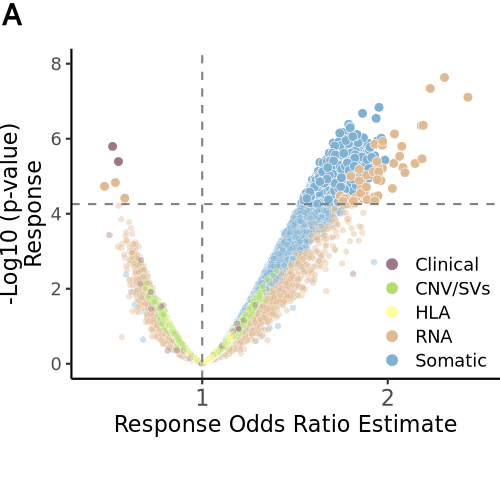

In [16]:
ingredients_plot = ingredients %>%
    filter(Group != "Gene Set",
           dataset == "all",
           model == "bor" ,
           covariates == "age_biopsy_purity_tissue")

fig2a = ggplot(ingredients_plot, aes(x = plot_est, y = log10_p,
                           size = log10_p > threshold, 
                           alpha = log10_p > threshold)) + 
    geom_point(aes(fill = big_group), shape = 21, stroke = 0.3, color = "white") + 
    scale_y_continuous(breaks = c(seq(0,8,2)), limits = c(0,8)) + 
    scale_x_continuous(breaks = c(1, 2), limits = c(0.4,2.5))  +
    scale_size_manual(values = c(2, 3))  +
    scale_alpha_manual(values = c(0.4, 1)) + 
    exhaustive_theme_left_legend + 
    theme(legend.position = "inside", legend.position.inside = c(0.85, 0.25),   legend.background = element_blank(),
          legend.box.background = element_blank()) + 
    scale_fill_manual(values = c("#9E7788", "#B3DE69","#FFFF99", "#e0ba92" ,"#80B1D3") ) +  # original color "#FC913A"
    geom_vline(xintercept = 1, linetype="dashed", color = "grey50", linewidth=0.7) + 
    geom_hline(yintercept = threshold, linetype="dashed", color = "grey50", linewidth=0.7) + 
    guides(alpha = "none", size = "none", # remove the 'pval size'
           fill = guide_legend(title = "", override.aes = list(size=4)),
           color = guide_legend(title = "")) +
    labs(title = "", x = "Response Odds Ratio Estimate", y = "-Log10 (p-value)\nResponse")    
fig2a <- annotate_figure(fig2a, fig.lab = "A", fig.lab.size = 20, fig.lab.face = "bold")
fig2a

In [17]:
# ggsave("../plots/Fig2A.png", fig2a ,bg='black', width = 15, height = 13, units = "cm")

### Figure 2B
Visualize clustering of co-correlating features using a correlation-heatmap

In [18]:
ready <- readRDS(paste0(I_DIR, "cpi_go.Rds"))
results <- readRDS(paste0(TMP_DIR,"exhaustive-plots-base.Rds"))
cutoff <- results$by_05_fdr[1]

In [19]:
# filter clinical features to have only a single result
results = results %>% filter(feature != "clinical_systemic_composite")

In [20]:
#initialize one_set_result and bor_set_result
one_set_result = bor_set_result = results %>% 
    filter(model == "bor", dataset == "all", covariates == "age_biopsy_purity_tissue") %>%
    unique()

In [21]:
top_bor_df <- results %>% 
    filter(model == "bor", dataset == "all", covariates == "age_biopsy_purity_tissue") %>% 
    filter(!feature %in% drop_features) %>%
    filter(!grepl("gene_set_", feature)) %>%
    filter(!grepl("cibersort", feature)) %>%
    filter(p_val < cutoff)
top_bor = top_bor_df  %>%  pull(feature)

In [22]:
bor_cor_go <- ready %>% select(all_of(top_bor)) %>% drop_na() 
cor_bor_with_pval <- rcorr(as.matrix(bor_cor_go))
cor_matrix_bor = cor(as.matrix(bor_cor_go), use = "pairwise.complete.obs")
colnames(cor_matrix_bor) <- colnames(bor_cor_go)
rownames(cor_matrix_bor) <- colnames(bor_cor_go)

In [23]:
for_heatmap_within_genes_bor <- cor_matrix_bor
for_heatmap_within_genes_bor_with_group = merge(as.data.frame(for_heatmap_within_genes_bor),
                                                one_set_result[c("feature","Type","big_group")],
                                                by.y = "feature", by.x = 0)

In [24]:
# cluster the correlation values
set.seed(12)
ord <- hclust(dist(1-cor_matrix_bor))$order

In [25]:
# Cluster RNA values to be able to split RNA features into a T-cell matrix and two outliers
cor_rna = cor_matrix_bor %>% as.data.frame() %>%
    rownames_to_column("feature") %>%
    filter(grepl("isofox", feature)) %>% 
    select(contains("isofox"), feature) %>% 
    column_to_rownames("feature")
cor_tree = hclust(dist(1-abs(cor_rna)), method = "ward.D2")
# set names for the tree-clustering method:
clusters = cutree(cor_tree, 2)

In [26]:
# check the number of genes for each of the RNA clusters
table(clusters)
# check which genes are not present in the cluster (BAIAP2, GGT5 and LATS2)
clusters[clusters == 2] 

clusters
 1  2 
48  3 

isofox_BAIAP2   isofox_GGT5  isofox_LATS2 
            2             2             2

In [27]:
# generate a widths-dataframe "wdf" with the widths of each of the features for visualization
# RNA fatures have a width of 3, 'Clinical' have a width of 40 and somatic (mutation) features have a width of 1
wdf <- one_set_result[,c("feature", "big_group")] %>% filter(feature %in% top_bor)
wdf$w = ifelse(wdf$big_group == "Clinical", 60, ifelse(wdf$big_group == "RNA", 3,1))
wdf = wdf[ord,]
wdf$big_group_fct = factor(wdf$big_group, levels = c("RNA", "Clinical", "Somatic"))
wdf = wdf %>% 
    mutate(cluster = big_group) %>% 
    mutate(cluster = case_when(clusters[feature] == 1 ~ "cluster 1",
                              clusters[feature] == 2 ~ "cluster 2",
                              .default = cluster)) %>% 
    mutate(cluster = factor(cluster, levels = c("cluster 1", "cluster 2", "Clinical", "Somatic")))

wdf$clustord = 1:nrow(wdf)
wdf = wdf %>% arrange(cluster, clustord)

# use the withs dataframe 'wdf' to calculate the x and y values for the different cells in the heatmap
breaks <- wdf %>% 
  mutate(cumw = cumsum(w),
         pos = .5 * (cumw + lag(cumw, default = 0))) %>% 
  select(feature, pos)

In [28]:
# make a "pd" dataframe with the correlations of the individual values
bor_cor_go = bor_cor_go %>% select(all_of(wdf$feature))
pd <- as.data.frame(cor_matrix_bor) %>% select(all_of(wdf$feature))
pd.m = pd %>%
    rownames_to_column("feature") %>% 
    pivot_longer(cols = -feature)

In [29]:
# Join the the 'pd.m' dataframe and the 'breaks' dataframe on feature. 
# This needs to be done twice to include the x and the y axis
pd.m <- pd.m %>%  
  left_join(breaks, by = "feature") %>% 
  rename(y = pos) %>% 
  left_join(breaks, by = c("name" = "feature")) %>% 
  rename(x = pos)

In [30]:
pd.m <- pd.m %>% 
  left_join(wdf, by = "feature")
pd.m <- pd.m %>% 
  left_join(wdf[,c(1,2,5)], by = c("name" = "feature"))

In [31]:
RNA_features = wdf[wdf$big_group == "RNA",]$feature
# factorize and reorder the x and y axis names of the pd.m object
pd.m$feature <- factor( pd.m$feature, levels = colnames(bor_cor_go))
pd.m$name <- factor(pd.m$name, levels = colnames(bor_cor_go))

In [32]:
pd.m$height = ifelse(pd.m$feature %in% c("clinical_pre_treated", "clinical_meta_hasSystemicPreTreatment2"), 60,
                     ifelse(pd.m$feature %in% RNA_features, 3,1))
pd.m$width = ifelse(pd.m$name %in% c("clinical_pre_treated", "clinical_meta_hasSystemicPreTreatment2"), 60,
                     ifelse(pd.m$name %in% RNA_features,3,1))

In [33]:
# Add the 'n value' to each column name in the plot
occurrences = table(wdf$cluster)
exp = paste0("Cluster R3\n(n = ", occurrences[1], ")")
snv_indel = paste0("Cluster R1\n(n = ", occurrences[4], ")")
clinical = paste0("Cluster R2\n(n = ", occurrences[3],")")

pd.m = pd.m %>% 
    mutate(Type = case_when(cluster.x == "cluster 1" ~ exp,
                            cluster.x == "cluster 2" ~ "cl2",
                            cluster.x == "Somatic" ~ snv_indel, 
                            cluster.x == "Clinical" ~ clinical)) %>% 
    mutate(Type2 = case_when(cluster.y == "cluster 1" ~ exp,
                            cluster.y == "cluster 2" ~ "cl2",
                            cluster.y == "Somatic" ~ snv_indel, 
                            cluster.y == "Clinical" ~ clinical))

# change the factor levels to order the plot in the same way
pd.m = pd.m %>%
    mutate(Type2 = factor(Type2, levels = c(snv_indel, clinical, exp, "cl2")), 
           Type = factor(Type, levels = c(snv_indel, clinical,exp, "cl2")))

In [34]:
# Some aestetic changes to the plot
colnames(pd.m)[3] <- "correlation"
colour_breaks <- c(10, 20, 30)
colours <- c("darkblue", "white", "darkred")

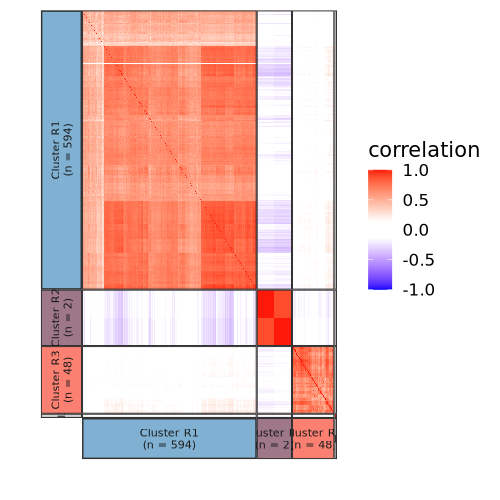

In [35]:
# plot the heatmap
fig2b <- ggplot(pd.m, aes(x = x, y = y)) +
  geom_tile(aes(width = width,  height = height, fill = correlation)) +
  scale_x_reverse(breaks = breaks$pos, labels = breaks$feature, expand = c(0, 0.0)) +
  scale_y_continuous(breaks = breaks$pos, labels = breaks$feature, expand = c(0, 0.0)) +
  scale_fill_gradientn(limits = c(-1, 1), 
                       colours = c("blue", "white", "white", "red"), 
                       values = c(0, 0.43, 0.57, 1.01)) +
  theme_bw(base_size = 15) +
  facet_grid2(Type ~ Type2, scales = "free", space = "free", switch = "both",render_empty = TRUE,
               strip = strip_themed(background_x = elem_list_rect(fill = c("#80B1D3","#9E7788","#FB8072", "lightgrey"), size= 1),
                                    background_y = elem_list_rect(fill = c("#80B1D3","#9E7788", "#FB8072", "lightgrey"), size= 1))) +
  theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
        strip.text.x = element_text(size = 8),
        strip.text.y = element_text(size = 8),
        panel.spacing.x = unit(0, "mm"),
        panel.spacing.y = unit(0, "mm"),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        panel.background = element_rect(fill = NA, color = "black", linewidth = 0),
        panel.grid  = element_blank(),
        legend.position = "right") + 
        xlab("") + ylab("")
fig2b
fig2b <- annotate_figure(fig2b, fig.lab = "B", fig.lab.size = 20, fig.lab.face = "bold") 

In [36]:
# ggsave("1_figures/figure2/Fig2B.png", fig2b ,bg='white', width = 15, height = 13, units = "cm")

### Figure 2C
Intermediate correlation plots
- Datapoints: HMF patients
- y = expression 'heatmap cluster' mean 
- x = expression geneset mean
- Take two genesets and display the correlation, to show how we get to point 2C 

In [37]:
# load gene sets
gsea_sets <- readRDS(paste0(REF_DIR,"GSEA_gene_sets.Rds"))
cpi_gene_sets <- readRDS(paste0(REF_DIR,"cpi1000_gene_sets.Rds"))
gsea_sets = gsea_sets[setdiff(names(gsea_sets), names(cpi_gene_sets))]
gene_sets = c(gsea_sets, cpi_gene_sets) # combine the two geneset lists
names(gene_sets) = gsub("gene_set_", "", names(gene_sets))
names(gene_sets) = gsub("gene_set_", "", names(gene_sets))

gene_sets = gene_sets[!grepl("battle_|tgfb_|vhio|08283|rand", names(gene_sets))]

# rename the geneset names
names(gene_sets) = tolower(names(gene_sets))
idx_mariathan = !names(gene_sets) %in% geneset_filtered_filtered$simplename
names(gene_sets)[idx_mariathan] = paste0("m_", names(gene_sets)[idx_mariathan])

In [38]:
# Select T-cell effector geneset as an example to show the correlation
select_sets = gene_sets[c("t_cell_effector")]
select_sets = lapply(select_sets, \(x) paste0("isofox_", x)) # add isofox to identify genes
cluster_genes = colnames(pd)[grep("isofox", colnames(pd))] 
total_sets = c(select_sets, list(cluster_mean = cluster_genes))
total_sets = sapply(total_sets, \(x) x[(x %in% colnames(ready))]) # select the number of genes not in the data

In [39]:
# generate cluster means: 
ready_m = ready |> select(starts_with("isofox")) |> as.matrix()# make matrix to allow for looping
patient_means = sapply(total_sets, \(x) rowMeans(ready_m[,x]))
colnames(patient_means)[1] = "T-Cell effector"

In [40]:
# generate the plotting dataframe - make it possible that the individual patient expression of the T-cell cluster, and cluster 3 are clearly visible.
pm = patient_means |> 
    as.data.frame() |>
    filter(!is.na(cluster_mean))

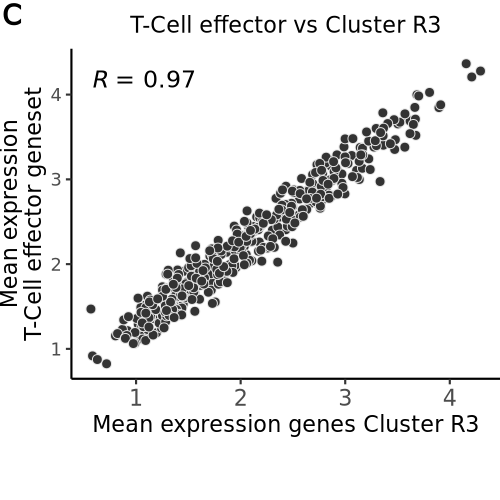

In [41]:
# For now, name the intermediate figure fig2bc
fig2c = ggplot(pm, aes(x = `T-Cell effector`, y = cluster_mean, fill = "Individual\npatient")) + 
  geom_point(color = "grey90", shape = 21, size = 3) + 
  exhaustive_theme_left +
  scale_fill_manual(values = "grey20") +
  ggpubr::stat_cor(aes(label = after_stat(r.label)), size = 6) + 
  theme(legend.position = "none") + 
  labs(y = "Mean expression\nT-Cell effector geneset", 
       x = "Mean expression genes Cluster R3", fill = NULL) + 
  ggtitle("T-Cell effector vs Cluster R3")
    
fig2c <- annotate_figure(fig2c, fig.lab = "C", fig.lab.size = 20, fig.lab.face = "bold")
fig2c

In [42]:
# ggsave("1_figures/figure2/Figure2C.png", fig2c, height = 6, width = 4)

### Figure 2D

In [43]:
# get the significant RNA genes
top_bor_RNA = top_bor_df  %>% 
    filter(big_group == "RNA")  %>% 
    pull(feature)

In [44]:
top_genes <- ready %>% 
    select(all_of(top_bor_RNA)) %>% 
    select(!all_of(c("isofox_BAIAP2", "isofox_LATS2", "isofox_GGT5")))  # remove the genes present in the subcluster

top_genes$cluster_mean = rowMeans(top_genes)
cor_genes<-cor(top_genes, use="pairwise.complete.obs")

In [45]:
gene_sets_expr <- ready %>% select(contains("gene_set_"))
colnames(gene_sets_expr) <- gsub("isofox_|gene_set_", "", colnames(gene_sets_expr))
colnames(gene_sets_expr) = gsub("mariathan_", "m_", colnames(gene_sets_expr))
colnames(gene_sets_expr) = tolower(colnames(gene_sets_expr))

In [46]:
top_genes_with_genesets = cbind(top_genes$cluster_mean, gene_sets_expr)
colnames(top_genes_with_genesets)[1]<-"Cluster_mean"

In [47]:
cor_to_cluster_mean <- data.frame("feature" = colnames(top_genes_with_genesets), 
                                  "Cor_with_cluster" = cor(top_genes_with_genesets,top_genes_with_genesets$Cluster_mean,use="pairwise.complete.obs")[,1])
cor_to_cluster_mean = cor_to_cluster_mean |> mutate(feature = sub("isofox_|gene_set_", "", feature))

In [48]:
bor_set_result_geneset = results  %>% 
    filter(model == "bor", dataset == "all", covariates == "age_biopsy_purity_tissue") %>%
    filter(Group == "Gene Set") 
bor_set_result_geneset$feature = gsub("isofox_|gene_set_", "", bor_set_result_geneset$feature)  %>% tolower()
bor_set_result_geneset$feature = gsub("mariathan_", "m_", bor_set_result_geneset$feature)

In [49]:
result2 <- merge(cor_to_cluster_mean, bor_set_result_geneset, by="feature")  %>% 
    mutate(selected = ifelse(Cor_with_cluster > 0.5 & log10_p > threshold, "selected", "no"))

In [50]:
result2$Short_name = geneset_filtered_filtered$Alias[match(result2$feature, geneset_filtered_filtered$simplename)]
result2 = result2  %>% filter(!is.na(Short_name))

In [51]:
geneset_filtered_filtered$Alias[!geneset_filtered_filtered$Alias %in% result2$Short_name]

character(0)

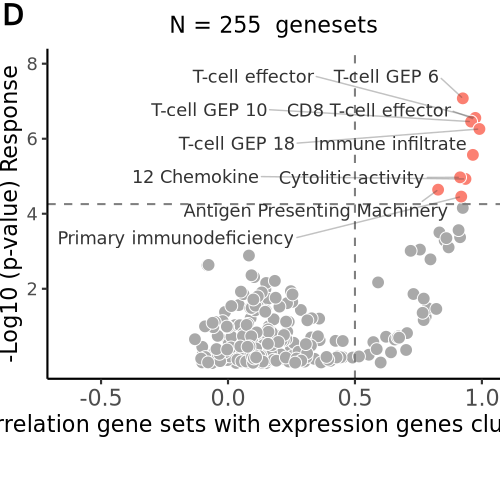

In [52]:
fig2d <- ggplot(result2, aes(x = Cor_with_cluster, y = log10_p, fill = selected)) +
    geom_point(size = 4, shape = 21, color = "white") +
    theme_bw() +
    scale_fill_manual(values=c("darkgrey","#FB8072")) +
    geom_vline(xintercept = 0.5, linetype="dashed", color = "grey50", linewidth =.7) +
    geom_hline(yintercept = threshold, linetype="dashed", color = "grey50", linewidth =.7) +
    geom_text_repel(aes(label = if_else((Cor_with_cluster > 0.5 & log10_p > threshold ), Short_name, "")), 
                    segment.alpha = 0.3,
                    force = 50,  nudge_x = -0.5 ,
                    min.segment.length = 0.3, box.padding = 0.5,
                  size=4.5, col="grey20" ,max.overlaps= Inf )+
    theme(legend.position="none") +
    theme(axis.title=element_text(size=16), axis.text = element_text(size = 16)) +
    scale_y_continuous(breaks = c(2,4,6,8), lim = c(0,8)) +
    labs(x = "Correlation gene sets with expression genes cluster R3", y ="-Log10 (p-value) Response", 
        title = paste0("N = ",nrow(result2), "  genesets")) +
    exhaustive_theme_left

fig2d <- annotate_figure(fig2d, fig.lab = "D", fig.lab.size = 20, fig.lab.face = "bold")
fig2d

In [53]:
# ggsave("1_figures/figure2/Figure2D.png", fig2d, height = 6, width = 6)

In [54]:
# for the next figure, save all the highly correlation gene sets
geneset_names = result2  %>% filter(Cor_with_cluster > 0.5)  %>% 
    select(feature, Short_name)
fwrite(geneset_names, "ref/T_cell_genesets.csv")

### New figure 2E
Plot the correlation of all the somatic mutation features against the mean of cluster 1: Somatic features

In [55]:
read_features = ready %>% select(any_of(unique(ingredients$feature)))

In [56]:
# get the features of each cluster
features_cl1 = wdf %>% filter(big_group == "Somatic") %>% pull(feature)
features_cl2 = wdf %>% filter(big_group == "Clinical") %>% pull(feature)
features_cl3 = wdf %>% filter(big_group == "RNA" & cluster == "cluster 1") %>% pull(feature)

In [57]:
mean_cl1 = rowMeans(ready %>% select(all_of(features_cl1)))
mean_cl2 = rowMeans(ready %>% select(all_of(features_cl2)))
mean_cl3 = rowMeans(ready %>% select(all_of(features_cl3)))

In [58]:
cluster_cors = data.table(feature = colnames(read_features),
                   `Cluster R1 = TMB` = cor(mean_cl1, read_features, use = "pairwise.complete.obs") %>% as.numeric(),
                   `Cluster R2 = Prior therapy` = cor(mean_cl2, read_features, use = "pairwise.complete.obs") %>% as.numeric(),
                   `Cluster R3 = T-cell` = cor(mean_cl3, read_features, use = "pairwise.complete.obs") %>% as.numeric())

Warning message in cor(mean_cl2, read_features, use = "pairwise.complete.obs"):
“the standard deviation is zero”


In [59]:
i_cors = ingredients %>% filter(model == "bor" & dataset == "all" & covariates == "age_biopsy_purity_tissue")  %>% 
    filter(Group != "Gene Set")

cluster_cors = cluster_cors %>% filter(feature %in% unique(i_cors$feature))
i_cors = left_join(i_cors, cluster_cors,by = "feature" )

In [60]:
# merge and filter the labels to match value: 
label_cors = labels %>%
    filter(model == "bor" & dataset == "all" & covariates == "age_biopsy_purity_tissue")
label_cors = left_join(label_cors, cluster_cors,by = "feature" ) %>% 
    filter(log10_p > threshold)

In [61]:
label_cors = label_cors %>% 
    filter(!clean_label %in% c("TGFB", "Proliferation", "Prior Systemic Therapy", "T-cell", "EIPR1", "TMEM117")) 

In [62]:
label_cors = label_cors %>% 
    select(starts_with("Cluster"), big_group, log10_p, clean_label) %>% 
    pivot_longer(cols = starts_with("Cluster"), names_to = "cluster", values_to = "correlation") %>% 
    filter(correlation > 0.75 & log10_p > 6)

In [63]:
input_cors = i_cors %>%  
    filter(model == "bor" & dataset == "all" & covariates == "age_biopsy_purity_tissue" & feature != "pretreat") %>% 
    select(starts_with("Cluster"), big_group, log10_p, feature) %>% 
    pivot_longer(cols = starts_with("Cluster"), names_to = "cluster", values_to = "correlation")

input_cors = input_cors %>% 
    filter(big_group %in% c("Somatic", "CNV/SVs") & cluster == "Cluster R1 = TMB"|
           big_group %in% c("Clinical", "HLA") & cluster == "Cluster R2 = Prior therapy" | 
           big_group == "RNA" & cluster == "Cluster R3 = T-cell")

input_cors = input_cors  %>% 
    mutate(in_cluster = case_when(
        feature %in% c(features_cl1, features_cl2, features_cl3) ~ "feature in cluster", 
        .default = '   '))  %>% 
    mutate(big_group2 = case_when(correlation > 0.5  & cluster == "Cluster R3 = T-cell" ~ "RNA: T-cell",
                                .default = big_group))

In [64]:
label_cors = input_cors  %>% 
    filter(cluster == "Cluster R1 = TMB" & grepl("TMEM117|EIPR1|TMB$|TMB_clonal$", feature) | 
          cluster == "Cluster R2 = Prior therapy" & in_cluster == "feature in cluster" | 
          cluster == "Cluster R3 = T-cell" & grepl("CXCL9|TIGIT|CD8A|GBP5|tcell", feature))  %>% 
    mutate(clean_label = gsub("somatic.|isofox_|.mb", "", feature))  %>% 
    mutate(clean_label = gsub("_", " ", clean_label))  %>% 
    mutate(clean_label = gsub("gene.", "TMB gene ", clean_label))  %>% 
    mutate(clean_label = case_when(clean_label == "clinical pre treated" ~ "Prior therapy", 
                                   clean_label == "clinical meta hasSystemicPreTreatment2" ~ "Prior systemic therapy",
                                   clean_label == "tcell" ~ "T-cell effector gene set",
                                  .default = clean_label))

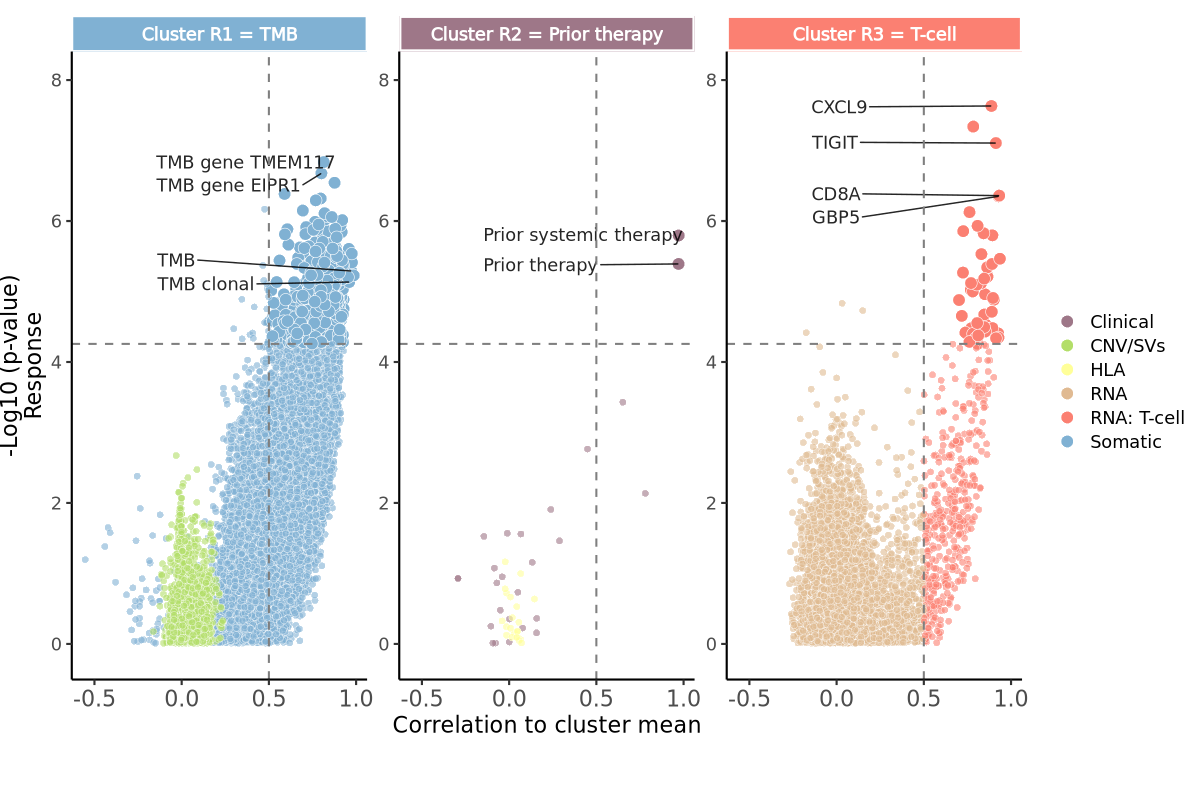

In [65]:
fig2e = input_cors %>%
    filter(!is.na(correlation)) %>%
        ggplot(aes(x = correlation, y = log10_p,
                   size = correlation > 0.5 & log10_p > threshold,
                   alpha = correlation > 0.5 & log10_p > threshold)) + 
        geom_point(aes(fill = big_group2), shape = 21, stroke = 0.3, color = "white") + 
        facet_grid2( . ~ cluster, axes = "y", 
                    strip = strip_themed(background_x = elem_list_rect(fill = c("#80B1D3","#9E7788","#FB8072"), size= 1))) +
        geom_text_repel(data = label_cors, aes(label = clean_label),direction = "y",hjust = 0, xlim = -0.17, alpha = 0.85, size = 4.5) + 
        exhaustive_theme_left_legend + 
        scale_y_continuous(breaks = c(seq(0,8,2)), limits = c(-0.1,8)) +
        scale_size_manual(values = c(2.2, 4)) + 
        scale_alpha_manual(values = c(0.6, 1)) + 
        scale_fill_manual(values = c("#9E7788", "#B3DE69","#FFFF99", "#e0ba92" ,"#FB8072", "#80B1D3")) +
        geom_vline(xintercept = 0.5, linetype="dashed", color = "grey50", linewidth=.7) +
        geom_hline(yintercept = threshold, linetype="dashed", color = "grey50", linewidth=.7) + 
        guides(alpha = "none", size = "none", color = "none", # remove legends for alpha, size and color
               fill = guide_legend(title = "", override.aes = list(size=4))) + 
       theme(strip.text = element_text(colour = 'white', face = "bold"),
             strip.background = element_rect(color = "white")) + 
       xlab("Correlation to cluster mean") + ylab("-Log10 (p-value)\nResponse") 

options(repr.plot.width=12, repr.plot.height=8)

fig2e

In [66]:
# save the T-cell cluster values (to be used in figure 3 later)
RNA_features = input_cors %>%
    filter(big_group2 == "RNA: T-cell")  %>%
    select(feature)

fwrite(RNA_features, "ref/features_Tcell.csv")

In [67]:
fig2e <- annotate_figure(fig2e, fig.lab = "E", fig.lab.size = 20, fig.lab.face = "bold") 
# ggsave("1_figures/figure2/figure2E.png", fig2e, width = 13, height = 5)

### Combining and saving plots

In [68]:
pl = list(fig2a, fig2b,  fig2c, fig2d, fig2e)
pl = lapply(pl, "+", theme(plot.margin=margin(5,10,5,5, unit = "mm")))
pl[[1]] = pl[[1]] + theme(plot.margin=margin(5,10,0,5, unit = "mm"))
pl[[2]] = pl[[2]] + theme(plot.margin=margin(5,0,0,0, unit = "mm"))
pl[[5]] = pl[[5]] + theme(plot.margin=margin(5,5,5,5, unit = "mm"))

In [69]:
lay = rbind(c(1,2), 
            c(3,4),
            c(5,5))

fig <- arrangeGrob(pl[[1]], pl[[2]], pl[[3]], pl[[4]],pl[[5]], layout_matrix=lay)  
ggsave("../..//final_figures/figure2.png", fig, width = 14, height = 18, dpi = 1100)
ggsave("../..//final_figures/figure2.pdf", fig, width = 14, height = 18, dpi = 1100)

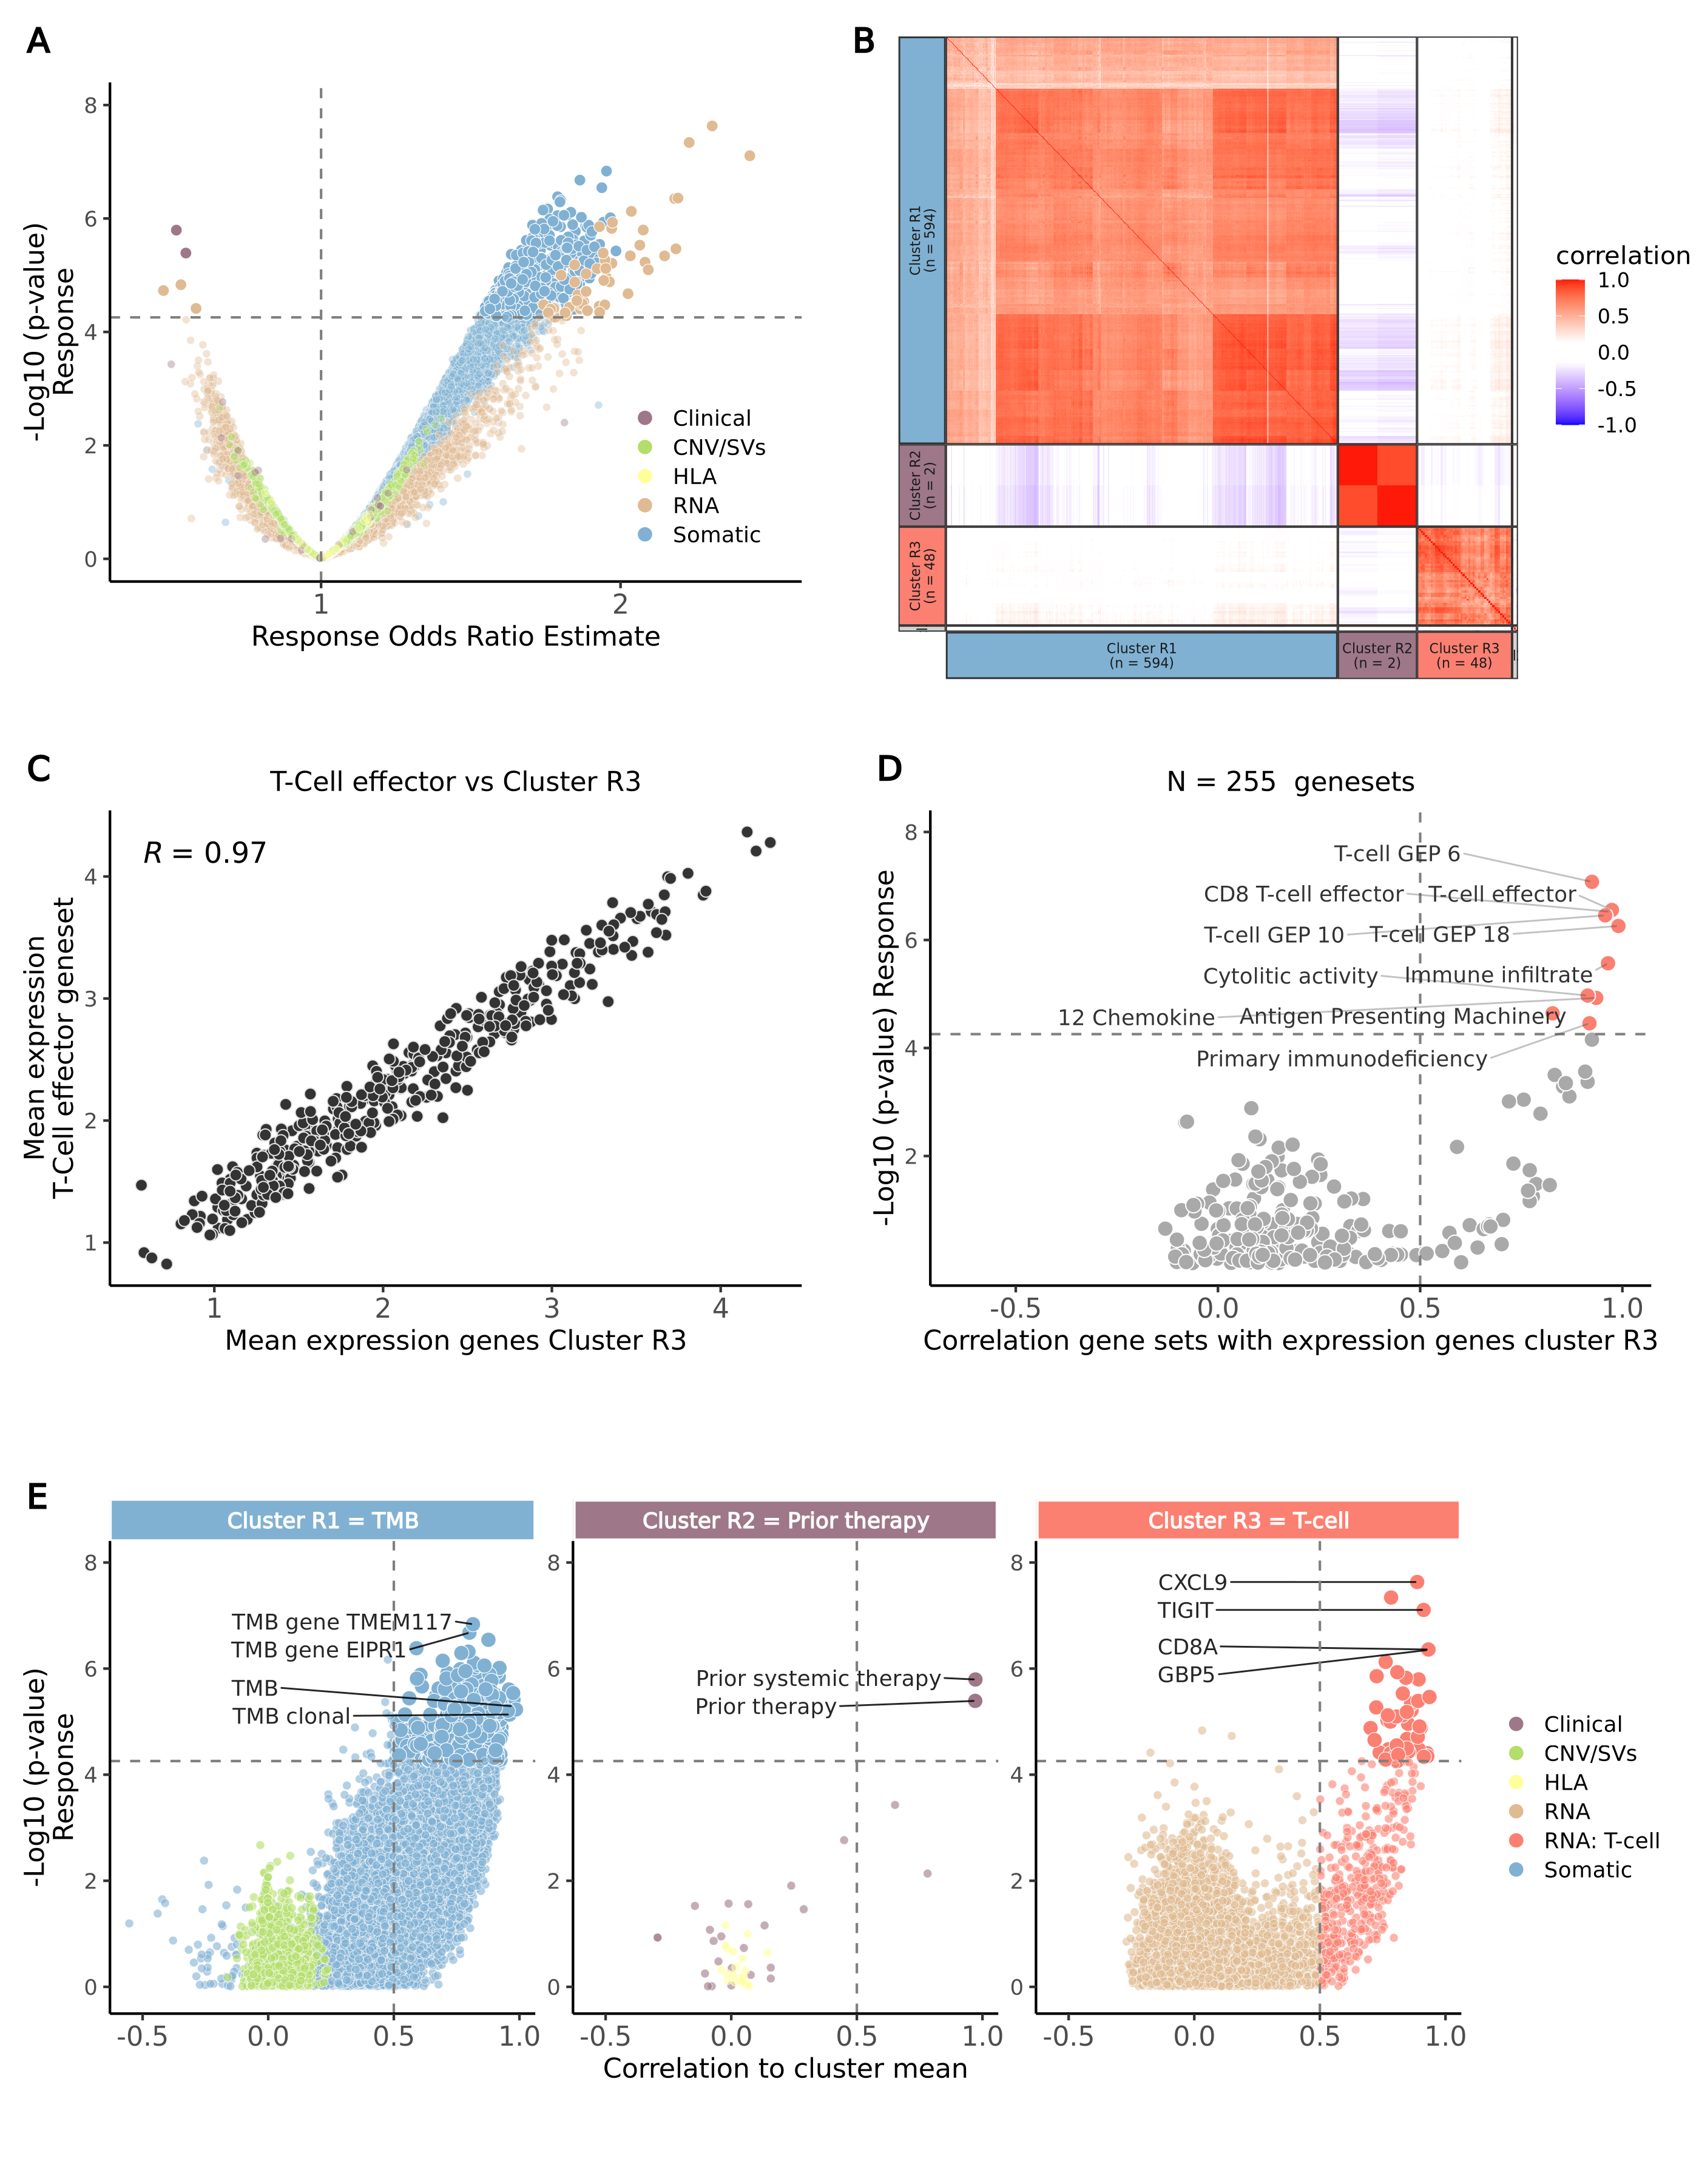

In [70]:
options(repr.plot.width = 14, repr.plot.height = 18, repr.plot.res = 200)
grid::grid.draw(fig)